# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Нужно довести долю правильных ответов по крайней мере до 0.75.

**План**
1. Изучение предоставленного файла.
2. Разделение исходного файла на обучающую, валидационную, тестовую выборки.
3. Исследование качества разных моделей, меняя гиперпараметры.
4. Проверка качества моделей на тестовой сборке.
5. Проверка модели на вменяемость.

## Откроем и изучим файл

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from scipy import stats as st
import numpy as np

In [13]:
df = pd.read_csv('/datasets/users_behavior.csv', dtype={'calls':np.int64, 'messages':np.int64})
df.info()
display(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   int64  
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   int64  
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 125.7 KB


,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0
...,...,...,...,...,...
3209,122,910.98,20,35124.90,1
3210,25,190.36,0,3275.61,0
3211,97,634.44,70,13974.06,0
3212,64,462.32,90,31239.78,0


**Вывод**

Действительно, в файле нет пропусков, заголовки столбцов в змеином регистре. Данные выглядят приемлемо для построения модели машинного обучения.

## Разобьем данные на выборки

Из предоставленного датасета выделим целевой признак - клиент находится на тарифе "Ультра" или нет.

Так как у нас нет тестовой выборки, разобъем нашу на три части: обучающую - 60%, валидационную - 20%, тестовую - 20%.

In [14]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [15]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.2, random_state=12345)

features_train, features_test, target_train, target_test = train_test_split(
    features_train, target_train, test_size=0.2, random_state=12345)
display('features_train', features_train)
display('features_test', features_test)
display('target_train', target_train)
display('target_test', target_test)
display('features_valid', features_valid)
display('target_valid', target_valid)

'features_train'

,calls,minutes,messages,mb_used
2388,3,35.47,62,11774.26
1777,58,325.83,48,15144.70
472,99,710.20,64,23674.04
3201,56,419.42,59,5177.62
1846,25,141.99,84,16150.12
...,...,...,...,...
1043,106,796.79,23,42250.70
2132,18,117.80,0,10006.79
1642,87,583.02,1,11213.97
1495,63,408.68,63,24970.26


'features_test'

,calls,minutes,messages,mb_used
2699,71,512.53,27,15772.68
242,183,1247.04,150,29186.41
2854,34,246.06,31,8448.76
1638,63,468.66,0,11794.34
1632,4,19.85,28,13107.42
...,...,...,...,...
1735,39,274.85,72,18436.72
1916,51,427.07,63,13108.17
496,96,597.80,45,13214.80
1037,56,357.36,0,12965.49


'target_train'

2388    1
1777    0
472     0
3201    1
1846    1
       ..
1043    1
2132    1
1642    0
1495    0
510     0
Name: is_ultra, Length: 2056, dtype: int64

'target_test'

2699    0
242     1
2854    0
1638    0
1632    0
       ..
1735    0
1916    0
496     0
1037    0
773     1
Name: is_ultra, Length: 515, dtype: int64

'features_valid'

,calls,minutes,messages,mb_used
1415,82,507.89,88,17543.37
916,50,375.91,35,12388.40
1670,83,540.49,41,9127.74
686,79,562.99,19,25508.19
2951,78,531.29,20,9217.25
...,...,...,...,...
2061,66,478.48,0,16962.58
1510,40,334.24,91,11304.14
2215,62,436.68,52,12311.24
664,117,739.27,124,22818.56


'target_valid'

1415    1
916     0
1670    0
686     1
2951    0
       ..
2061    0
1510    0
2215    0
664     1
1196    0
Name: is_ultra, Length: 643, dtype: int64

## Исследование моделей

В нашем исследовании попробуем обучить решающее дерево, случайный лес и логистическую регрессию. 

Первым на очереди решающее дерево. Так как в задании определен порог accuracy в 0,75, попробуем циклами перебирать разные значения для гиперпараметров и возьмем лучшее из них в финальную модель. Ограничим себя треми гиперпараметрами: максимальной глубиной дерева - `max_depth`, минимальное количество листьев для разделения внутреннего узла - `min_samples_split`, минимальное количество листьев для конечного узла - `min_samples_leaf`. Пробовал во время эксперимента менять `criterion` на `entropy`, accuracy оказалось на 5% ниже чем с `gini`.

In [16]:
best_model = None
best_result = 0
best_depth = 0

model = DecisionTreeClassifier(random_state=12345).fit(features_train, target_train)
result = model.score(features_valid, target_valid)
display(f"Accuracy до изменения гиперпараметров: {result:.3f}")

for depth in range(1, 10):
    model = DecisionTreeClassifier(
        random_state=12345, 
        max_depth=depth
    ).fit(features_train, target_train)
    
    result = model.score(features_valid, target_valid) # найдем качество модели на валидационной выборке
    if result > best_result:
        best_model = model # сохраним наилучшую модель
        best_result = result #  сохраним наилучшее значение метрики accuracy на валидационных данных
        best_depth = depth
        
for min_samples_split in range(2, 10):
    model = DecisionTreeClassifier(
        random_state=12345, 
        max_depth=best_depth,
        min_samples_split=min_samples_split
    ).fit(features_train, target_train)
     
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_min_samples_split = min_samples_split        

for min_samples_leaf in range(1, 30):
    model = DecisionTreeClassifier(
        random_state=12345, 
        max_depth=best_depth,
        min_samples_split=best_min_samples_split,
        min_samples_leaf=min_samples_leaf
    ).fit(features_train, target_train)
    
    result = model.score(features_valid, target_valid)
    if result > best_result:
        best_model = model
        best_result = result
        best_min_samples_leaf = min_samples_leaf          

model_tree = best_model        
display(f"Accuracy наилучшей модели на валидационной выборке: {best_result:.3f}")

'Accuracy до изменения гиперпараметров: 0.731'

'Accuracy наилучшей модели на валидационной выборке: 0.798'

**Вывод**

После изменения гиперпараметров удалось увеличить accuracy с 0,73 до 0,798. Оставим модель такой и рассморим другие типы.

Вторым, рассотрим случайный лес. Здесь, как и в предыдущем попробуем изменить три гиперпараметра:
* `n_estimators` - количество деревьев в нашем лесу;
* `max_depth` - максимальная глубина дерева;
* `min_samples_leaf` - минимальное количество листьев для конечного узла

In [17]:
best_model = None
best_result = 0

# Так как в версии 0.22 изменили стандартные настройки 
# n_estimators на 100, примем это значение.
model = RandomForestClassifier(random_state=12345, n_estimators=100).fit(features_train, target_train)
result = model.score(features_valid, target_valid)
display(f"Accuracy до изменения гиперпараметров: {result:.3f}")

for est in range(1, 150):
    model = RandomForestClassifier(random_state=12345, n_estimators=est) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    result = model.score(features_valid, target_valid) # посчитайте качество модели на валидационной выборке
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_est=est
        
for depth in range(1, 10):
    model = RandomForestClassifier(
        random_state=12345, 
        n_estimators=best_est,
        max_depth=depth,
    ) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    result = model.score(features_valid, target_valid) # посчитайте качество модели на валидационной выборке
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_depth=depth

for samples_leaf in range(1, 10):
    model = RandomForestClassifier(
        random_state=12345, 
        n_estimators=best_est,
        max_depth=best_depth,
        min_samples_leaf=samples_leaf
    ) # обучите модель с заданным количеством деревьев
    model.fit(features_train, target_train) # обучите модель на тренировочной выборке
    result = model.score(features_valid, target_valid) # посчитайте качество модели на валидационной выборке
    if result > best_result:
        best_model = model # сохраните наилучшую модель
        best_result = result #  сохраните наилучшее значение метрики accuracy на валидационных данных
        best_min_samples_leaf=samples_leaf      

model_forest = best_model        
display(f"Accuracy наилучшей модели на валидационной выборке: {best_result:.3f}")

'Accuracy до изменения гиперпараметров: 0.788'

'Accuracy наилучшей модели на валидационной выборке: 0.801'

**Вывод**

Случайный лес - один из самых точных моделей, что и показывает наш эксперимент - точность модели до изменения гиперпараметров почти 0,79, как у настроенного решающего дерева. Увеличение точности после настройки на 2% - не так много, как в предыдушей модели, но в данный момент - это самая точная модель. Посмотрим что нам даст логистическая регрессия.

In [18]:
model_logistic = LogisticRegression(random_state=12345, solver='lbfgs')
model_logistic.fit(features_train, target_train)
result = model_logistic.score(features_valid, target_valid)

display(f"Accuracy модели логистической регрессии на валидационной выборке: {result:.3f}")

'Accuracy модели логистической регрессии на валидационной выборке: 0.760'

**Вывод**

Так как обычно модель на основе логистической регресси не отличается большой точностью, то оставим ее без настройки. Посмотрим что покажут все три модели в тесте.

## Проверьте модель на тестовой выборке

Сведем accuracy в один датафрейм, столбцы будут соответствовать выборкам: тренировочной, валидационной и тестовой, а строки - моделям. После этого посроим график зависимости точности модели от типа и выборки.

,train,valid,test
tree,0.834630,0.797823,0.765049
forest,0.862840,0.800933,0.778641
logistic,0.753891,0.760498,0.716505


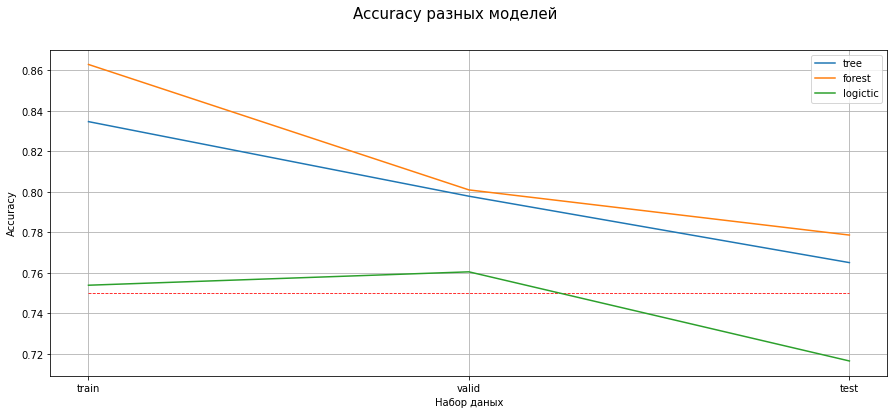

In [19]:
index = ['tree', 'forest', 'logistic']
data = {'train':[],
        'valid':[],
        'test':[]}
for i,j in data.items():
    if i == 'train':
        j.append(model_tree.score(features_train, target_train))
        j.append(model_forest.score(features_train, target_train))
        j.append(model_logistic.score(features_train, target_train))
    if i == 'valid':
        j.append(model_tree.score(features_valid, target_valid))
        j.append(model_forest.score(features_valid, target_valid))
        j.append(model_logistic.score(features_valid, target_valid))
    if i == 'test':
        j.append(model_tree.score(features_test, target_test))
        j.append(model_forest.score(features_test, target_test))
        j.append(model_logistic.score(features_test, target_test))

accuracy = pd.DataFrame(data=data, index=index)
display(accuracy)

#####################################
# Для наглядности построим график Accuracy по разным моделям

fig, ax = plt.subplots()

x = accuracy.columns
y1 = accuracy.loc['tree']
y2 = accuracy.loc['forest']
y3 = accuracy.loc['logistic']

fig.set_figwidth(15)
fig.set_figheight(6)
fig.suptitle('Accuracy разных моделей', fontsize = 15)

ax.plot(x, y1, label = 'tree')
ax.plot(x, y2, label = 'forest')
ax.plot(x, y3, label = 'logictic')

ax.legend()

ax.set_xlabel('Набор даных')
ax.set_ylabel('Accuracy')
ax.grid()

# Добавим горизонтальную линию на высоте 0,75, для обозначения порога
ax.hlines(0.75, 0, 2, 
          color='r',
          linewidth=0.8,
          linestyle='--')

plt.show()

**Вывод**

По нашему графику видно, что модель на основе логистической регресии уступает остальным по всем выборкам. Настроенные модели решающего дерева и случайного леса идут очень близко друг к другу, но лес лучше дерева.

## (бонус) Проверьте модели на адекватность

Обучим престейшую модель, которая предсказывает постоянное число, в одном случае 0, в другом - 1. Выбрали данные числа, так как клиент либо имеет тариф "Ultra" - 1, либо имеет тариф "Smart" - 0. Посмотрим насколько точно получится предсказать.

In [20]:
dummy_clf = DummyClassifier(strategy='constant', random_state=12345, constant=0)
dummy_clf.fit(features_train, target_train)
display(f'accuracy, когда константа = 0: {dummy_clf.score(features_train, target_train):.3f}')

dummy_clf = DummyClassifier(strategy='constant', random_state=12345, constant=1)
dummy_clf.fit(features_train, target_train)
display(f'accuracy, когда константа = 1: {dummy_clf.score(features_train, target_train):.3f}')

'accuracy, когда константа = 0: 0.697'

'accuracy, когда константа = 1: 0.303'

Модель, которая предсказывает контсанту, точна при 0 на 70%, при 1 - в 30%. Такое может быть из-за неравномерности классов в тестовой выборке. Примем за правильную константую модель, предсказывающую 0, так как у нее показатель точности выше.

Простейшая модель ошибается в 30% случаев, наша, самая лучшая в 22%. Думаю можно считать модель адекватной.

# Вывод

В результате рассмотрения трех моделей классификации, а именно: решающего дерева, случайного леса и логистической регрессии, пришли к выводу что случайный лес оказался наиболее точным в предсказаниях чем два других. Точность моделей удалось немного поднять по отношению к модели с настройками гиперпараметров по умолчанию. 